In [7]:
# import the required packages

import numpy as np
from lightcones.linalg import mv
from lightcones import models
from lightcones.solvers.schrodinger import solve
import matplotlib.pyplot as plt

In [8]:
# use latex for plotting
# requires installed latex 
# comment if do not need it 

plt.rcParams['text.usetex'] = True

In [15]:
# define the Hamiltonian of the spin-boson model

# number of boson chain modes
num_chain_modes = 15

# keep in the truncated Fock space only states in which 
# the bosonic chain has no more than max_num_quanta quanta
max_num_quanta = 5

# sparse matrices for the model
m = models.spin_boson(num_chain_modes, max_num_quanta)

# Hamitonian for the spin (qubit)
# Rabi (level splitting)
Omega = 2.0
Hs = m.s_p @ m.s_m * Omega / 2

# Coupling to the chain via raising / lowering Pauli matrices
# coupling strength g
g = 0.05
V = g * m.s_m @ m.a_dag[0]
V_dag = V.T.conj()

# Free bosonic chain Hamiltonian (on-site energy e and hopping h)
e = 1.0
h = 0.05
Hb = e * sum([m.a_dag[i] @ m.a[i] for i in range(num_chain_modes)]) \
    + h * sum([m.a_dag[i + 1] @ m.a[i] + m.a_dag[i] @ m.a[i + 1] for i in range(num_chain_modes - 1)])
    
# joint Hamiltonian
Hsb = Hs + V + V_dag + Hb

# The qubit is periodically driven
def drive(t):
    return(0.1*np.cos(t)) * m.s_x

# The Hamiltonian for the driven spin-boson model
def Hsb_driven(t):
    return Hsb + drive(t)

In [16]:
# The non-stationary Schrodinger equation is solved on a time grid
# [0    dt    2*dt    ...    k*dt  ... ]
# The time grid points are numbered by integer ti
# [0    1     2       ....   k     ... ]
# The time-dependent Hamiltonian is invoked by the solver with ti argument,
# and the corresponding time moment is (ti + 0.5)*dt
# Here 0.5*dt is due to the midpoint integration rule

# Time step
dt = 0.01

# Final grid
t_max = 100
t = np.arange(0, t_max + dt, dt)
n_time = t.size

# Callback function which applies Hamiltonian to the wavefunction at each time grid point ti
def apply_h(ti, psi_in, psi_out):
    H = Hsb_driven((ti + 0.5) * dt)
    mv(H, psi_in, psi_out, cout=1)

# Here we store the average of observables
s_z_av = []

# Callback function which evaluates observables at each time grid point ti
def eval_o(ti, psi):
    s_z_av.append(np.vdot(psi, m.s_z @ psi))
    
# initial condition:
# vacuum state for bosonic chain,
# and ground state for spin (qubit)
psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1.0 
    
# Solve the non-stationary Schrodinger equation
solve(0, n_time-1, dt, apply_h, psi_0, eval_o = eval_o)

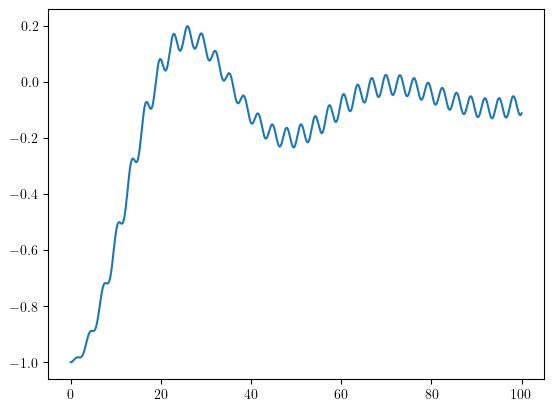

In [18]:
# plot the s_z average 
s_z_av = np.array(s_z_av)
plt.plot(t, s_z_av.real)
# save picture to file
plt.savefig('s_z_av_spin_boson_model.eps', format='eps')

In [19]:
# save computed averages to text file

s_z_av_table = np.column_stack((t, s_z_av.real))
np.savetxt('s_z_av_spin_boson.txt', s_z_av_table, delimiter=' ')